In [350]:
import os 
import matplotlib.pyplot as plt
import torchvision 
import random
from scipy.signal import resample
import torch
import torch.nn.functional as F

print("Current path:", os.getcwd())
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

Current path: /home/ubuntu/BrainDecoding


In [351]:
class RandomResample(object):
    def __init__(self, min_freq=40, max_freq=120, probability=0.25):
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.probability = probability

    def __call__(self, data: torch.Tensor):
        if random.random() < self.probability:
            return self.random_resample(data)
        return data

    def random_resample(self, data: torch.Tensor):
        """
        data: Tensor of shape [channels, time]
        """
        original_length = data.shape[-1]
        resample_freq = random.randint(self.min_freq, self.max_freq)
        target_length = int(original_length * resample_freq / 120)
        
        resampled_data = F.interpolate(
            data, size=target_length, mode='linear', align_corners=True
        )
        
        restored_data = F.interpolate(
            resampled_data, size=original_length, mode='linear', align_corners=True
        )
        
        return restored_data

class MEGTransform(object):
  def __init__(self):
    self.meg_transform = torchvision.transforms.Compose([
        #RandomResample(min_freq=15, max_freq=15, probability=1),
        #torchvision.transforms.RandomVerticalFlip(1),
        #torchvision.transforms.RandomErasing(p=1, scale=(0.25, 0.33), value=0),
        #torchvision.transforms.RandomResizedCrop((268, 480), scale=(0.2, 0.5), ratio=(268/480, 268/480)),
    ])
  def __call__(self, sample):
    sample = sample.unsqueeze(0)
    sample = self.meg_transform(sample)
    sample = sample.squeeze(0)
    return sample

In [ ]:
import os
import numpy as np
import torch
import torchvision
import mne
from sklearn.preprocessing import RobustScaler
from functools import partial
from termcolor import cprint

def scale_clamp(X: np.ndarray, clamp_lim: float = 5.0, clamp: bool = True) -> np.ndarray:
  X = X.reshape(X.shape[0], -1)
  X = RobustScaler().fit_transform(X)
  if clamp:
      X = X.clip(min=-clamp_lim, max=clamp_lim)
  return X.squeeze()

class meg_dataset(torch.utils.data.Dataset):
  def __init__(self, config, s: int, transform: bool, train: bool):
    self.train = train
    if transform:
      self.meg_transform = MEGTransform()
    else:
      self.meg_transform = torchvision.transforms.Compose([
      ])
    self.root = config['root_dir']
    nights = ['Night1', 'Night2', 'Night3', 'Night4']
    if s == 4 or s == 5:
      nights = ['Night1', 'Night3', 'Night4', 'Night5']
    np.random.seed(s)
    np.random.shuffle(nights)
    if train: 
      nights = nights[:3]
    else:
      nights = nights[3:]
    self.s = s
    s = f"S{int(s):02d}"
    mne.set_config('MNE_USE_CUDA', 'true')
    self.all_meg_data = []
    self.all_epochs = []
    cprint("Analysing Subject: " + s + ", nights: " + str(nights), 'blue', attrs=['bold'])
    for night in nights:
      print(f"Loading {s} {night}")
      data_path_folder = os.path.join(self.root, s, night)
      files = [f for f in os.listdir(data_path_folder)]
      files.sort()
      wm = files[-1]
      self.data_path = os.path.join(self.root, s, night, wm)

      raw = mne.io.read_raw_ctf(self.data_path, preload=True, verbose=False)
      raw.pick_types(meg=True, stim=True, eeg=False, ref_meg=False, verbose=False)
      if "MRP54-4016" in raw.ch_names:
        raw.drop_channels(["MRP54-4016"])
      if config["filter"]:
        raw.filter(config["filter_low"], config["filter_high"], picks='mag', n_jobs='cuda', h_trans_bandwidth=config["filter_high"]/10, l_trans_bandwidth=config["filter_low"]/10, verbose=False)
      events = mne.find_events(raw, stim_channel='UDIO001', initial_event=True, verbose=False)

      event_ids = {"maint_FACE": 43, "maint_HOUSE": 53}

      events[:,2] = events[:,2] - 256
      picks = mne.pick_types(raw.info, meg='mag', eeg=False, stim=False, ref_meg=False)
      self.epochs = mne.Epochs(raw, events, event_ids,  picks=picks, tmin=0, tmax=4,\
                          baseline=None, preload=True, verbose=False)
      self.epochs.resample(120, n_jobs='cuda', verbose=False)
      self.epochs.apply_function(partial(scale_clamp, clamp_lim=config["clamp"]), n_jobs=10, verbose=False)
      if config["spectrogram"]:
        freqs = np.linspace(0.1, 32, 268)
        #n_cycles = ((0.5 - (0.5 - 0.1) * (freqs - 1) / 25)**2) + 0.1
        n_cycles = freqs / 2.0
        power = self.epochs.compute_tfr(method='morlet', freqs=freqs, n_cycles=n_cycles, average=False, picks='meg', verbose=False)
        self.meg_data = torch.from_numpy(power.data.mean(axis=1)).to(torch.float32)
        print("Spectrogram shape: ", self.meg_data.shape)
      else:
        self.meg_data = torch.from_numpy(self.epochs.get_data(picks='meg')).to(torch.float32)
        print("MEG shape: ", self.meg_data.shape)
      self.all_meg_data.append(self.meg_data)
      self.all_epochs.append(self.epochs)

    self.all_meg_data = torch.cat(self.all_meg_data, dim=0)
    for ep in self.all_epochs:
      ep.info['dev_head_t'] = self.all_epochs[0].info['dev_head_t']
    self.all_epochs = mne.concatenate_epochs(self.all_epochs, verbose=False)

    #np.random.shuffle(self.all_epochs.events[:, 2])
    
  def __len__(self):
    return len(self.all_meg_data)
  
  def __getitem__(self, idx):
    return self.meg_transform(self.all_meg_data[idx, :, :]), self.all_epochs.events[idx, 2], self.s

In [384]:
config = {
    "root_dir": "/vol/megdata/raw/",
    "clamp": 5.0,
    "filter": False,
    "filter_low": 0.3,
    "filter_high": 4,
    "spectrogram": True,
}
subjects = 2
dataset = meg_dataset(
  config=config, s = subjects, transform=True, train = False
)
#val_dataset = meg_dataset(
#  config=config, s = subjects, transform=False, train = False
#)
train_idcs = np.arange(0, len(dataset))
np.random.seed(42)
np.random.shuffle(train_idcs)
train_idcs = train_idcs[:int(len(train_idcs)*0.8)]
val_idcs = np.setdiff1d(np.arange(0, len(dataset)), train_idcs)
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
#val_dataset = torch.utils.data.Subset(val_dataset, val_idcs)

Analysing Subject: S02, nights: ['Night1']
Loading S02 Night1
Spectrogram shape:  torch.Size([50, 268, 480])


/tmp/ipykernel_3193310/1373026594.py:81: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  self.all_epochs = mne.concatenate_epochs(self.all_epochs, verbose=False)


torch.Size([268, 480])


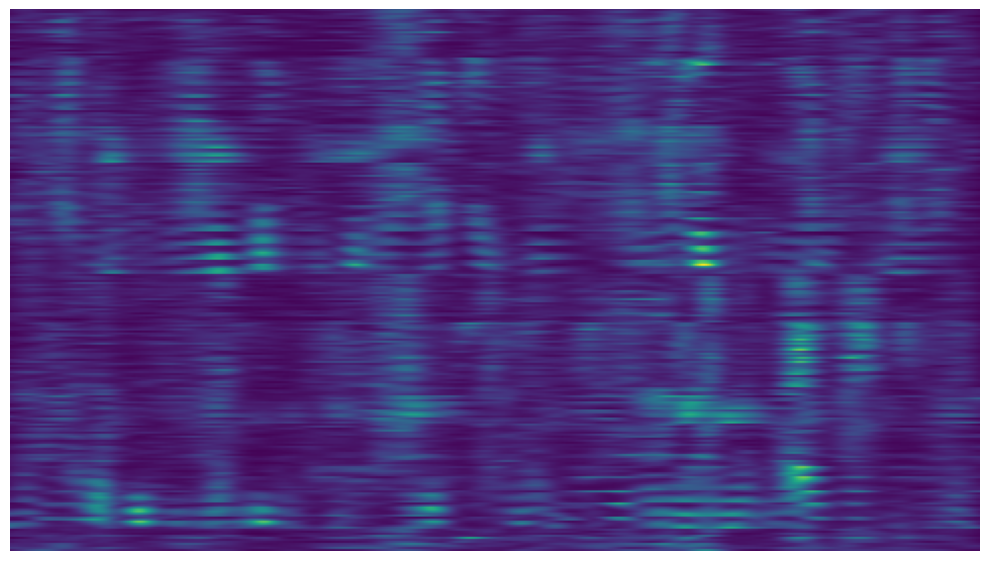

: 

In [ ]:
ds = train_dataset
fig, ax = plt.subplots(1,1, figsize=(10, 7), dpi = 100)
meg, label, _ = ds[4]
ax.imshow(meg, cmap = 'viridis')
ax.axis('off')
print(meg.shape)
plt.tight_layout()
plt.show()

torch.Size([268, 480])
torch.Size([268, 480])


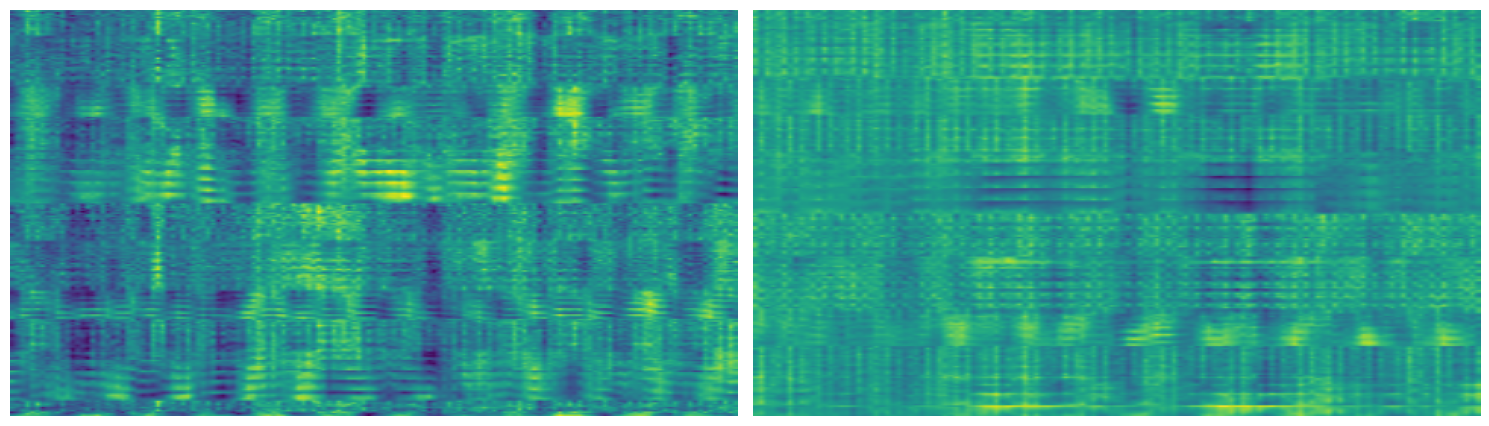

In [301]:
ds = train_dataset
fig, ax = plt.subplots(1,2, figsize=(15, 8), dpi = 100)
for idx, ax in enumerate(ax):
  meg, label, _ = ds[idx]
  ax.imshow(meg, cmap = 'viridis')
  ax.axis('off')
  print(meg.shape)
plt.tight_layout()
plt.show()

In [ ]:
print("number of unique meg trials: ", len(np.unique(meg.numpy(), axis=0)))

number of unique meg trials:  268


In [ ]:
print(len(dataset))

50
